# Timeseries_05-FinalModel

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It is based on parameters that seem best from experimentation in the Timeseries_02-PlayWithModels and Timeseries_03-BuildFullModels notebooks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer. This well will not be used, as the data has more gaps than LWPH4b.
 - `LWPH4b` = deep alluvial aquifer. This is the target that we are trying to simulate.
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.

We also have:
 - `stage_masl` = river stage elevation. This is `NaN` whenever flow in the river ceases.
 - `WaterUse_m3d` = estimated groundwater pumping within 4 km radius, based on uniform daily distribution of annual values.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'WaterYear', 'WaterUse_m3d', 'LWPH4a', 'LWPH4a_source', 'LWPH4b', 'LWPH4b_source', 'LWPH4c', 'LWPH4c_source', 'regime_number', 'regime_category']


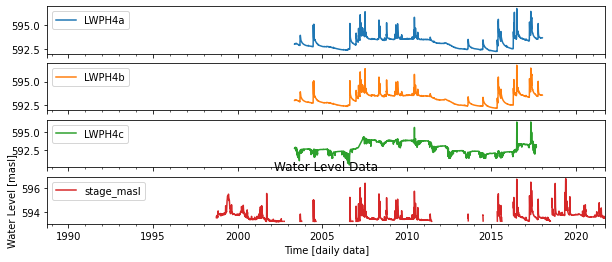

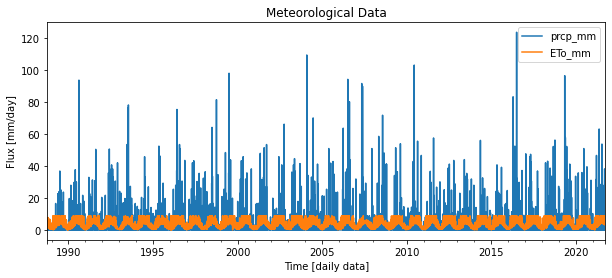

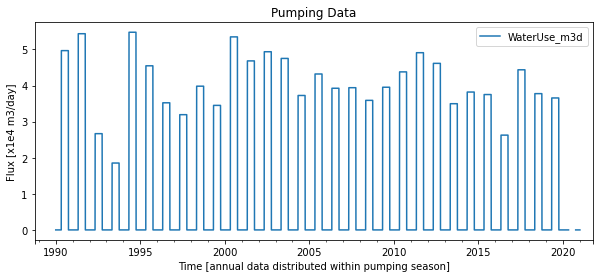

In [3]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4), subplots=True)
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');

wusedata = inputdata[["WaterUse_m3d"]]/1e4
wusedata.plot(figsize=(10, 4))
plt.title('Pumping Data');
plt.ylabel('Flux [x1e4 m3/day]');
plt.xlabel('Time [annual data distributed within pumping season]');
# 2021 water use data are not available, but that's OK because the groundwater level data end in 2018

## Build model

INFO: Nan-values were removed at the start of the time series LWPH4b.
INFO: Nan-values were removed at the end of the time series LWPH4b.
INFO: Inferred frequency for time series LWPH4b: freq=D
INFO: Inferred frequency for time series prcp_mm: freq=D
INFO: Inferred frequency for time series ETo_mm: freq=D
INFO: Nan-values were removed at the start of the time series WaterUse_m3d.
INFO: Nan-values were removed at the end of the time series WaterUse_m3d.
INFO: Inferred frequency for time series WaterUse_m3d: freq=D
INFO: Time Series WaterUse_m3d: 153 nan-value(s) was/were found and filled with: 0.0.
INFO: Inferred frequency for time series stage_masl: freq=D


Fit report LWPH4b                        Fit Statistics
nfev    33                     EVP           89.34
nobs    5352                   R2             0.89
noise   1                      RMSE           0.20
tmin    2003-05-16 00:00:00    AIC        10458.83
tmax    2018-01-08 00:00:00    BIC        10531.26
freq    D                      Obj            3.50
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (11 optimized)
                   optimal   stderr      initial   vary
recharge_A        2.592655  ±16.05%     4.906329   True
recharge_a      555.452592  ±14.73%   698.055820   True
recharge_srmax  154.555333   ±6.63%    99.754801   True
recharge_lp       0.250000    ±nan%     0.250000  False
recharge_ks      28.335114  ±21.84%    18.540795   True
recharge_gamma    3.081034  ±12.01%    10.827137   True
recharge_simax    2.000000    ±nan%     2.000000  False
recharge_kv       1.000000    ±nan%     1.000000  False
well_

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['prcp_mm', 'ETo_mm']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['WaterUse_m3d']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['stage_masl']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=11)'}>]

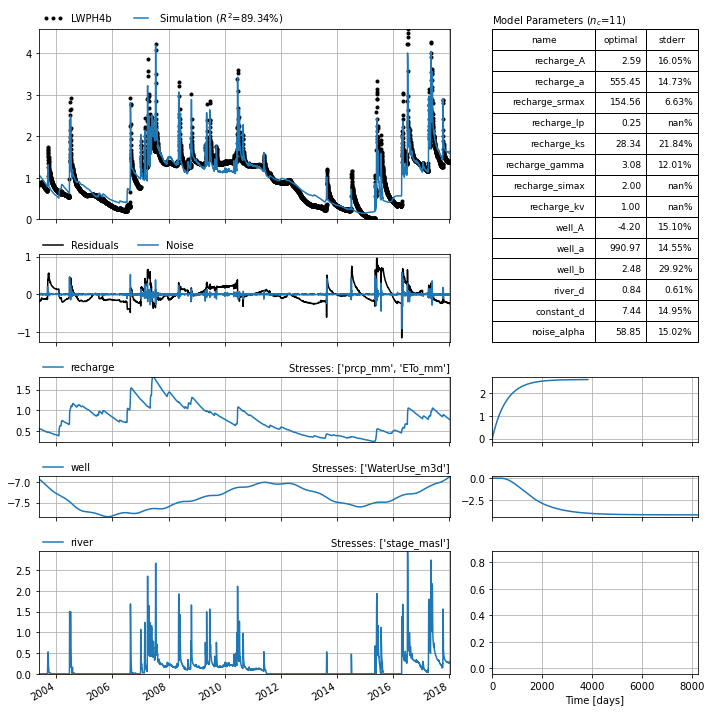

In [4]:
# normalize groundwater levels to min value
lwph4b = (hydrodata["LWPH4b"] - hydrodata["LWPH4b"].min()).asfreq("D")

# Create a model object by passing it the observed series
ml_lwph4b = ps.Model(lwph4b, name="LWPH4b")

## build stress models:
# recharge - following Collenteur et al. (2021)
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]
sm_rech = ps.RechargeModel(metdata["prcp_mm"], metdata["ETo_mm"], rfunc=ps.Exponential, 
                           recharge=ps.rch.FlexModel(), name="recharge")

# pumping
wuse = ps.StressModel(wusedata, rfunc=ps.Hantush, name="well", settings="well", up=False)

# river stage
river = (hydrodata["stage_masl"] - hydrodata["stage_masl"].min()).asfreq("D").fillna(0)
sm_river = ps.StressModel(river, rfunc=ps.One, name="river",
                           settings="waterlevel")

## add models
ml_lwph4b.add_stressmodel(sm_rech)
ml_lwph4b.add_stressmodel(wuse)
ml_lwph4b.add_stressmodel(sm_river)

# solve
ml_lwph4b.solve(noise=False, report=False) # Solve first without noise model to improve initial parameters
ml_lwph4b.solve(noise=True, initial=False)

# plot
ml_lwph4b.plots.results(figsize=(10, 10))

## Write CSV files so you can plot in R

Daily timeseries and response functions for recharge, well, and river

In [9]:
daily_output = pd.DataFrame({'obs':  ml_lwph4b.observations(),
                             'resid': ml_lwph4b.residuals(),
                             'well': ml_lwph4b.get_contribution("well"),
                             'recharge': ml_lwph4b.get_contribution("recharge"),
                             'river': ml_lwph4b.get_contribution("river"),
                             'noise': ml_lwph4b.noise()})

daily_output.to_csv("../data/Timeseries_FinalModel_DailyOutput.csv")

responses = pd.DataFrame({'well': ml_lwph4b.get_block_response("well"),
                          'recharge': ml_lwph4b.get_block_response("recharge"),
                          'river': ml_lwph4b.get_block_response("river")})

responses.to_csv("../data/Timeseries_FinalModel_ResponseFuncs.csv")